In [1]:
import numpy as np
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.special import softmax
from JADE.FastJADE import preprocess_jade_data, FastJADE
from JADE.utils import * 
from JADE.preprocess import *
from utils import *
import warnings
warnings.filterwarnings('ignore')

### **Read DLPFC data**

In [18]:
# Read DLPFC data.
sns.set_style('whitegrid')
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adata_all = {sample:sc.read_h5ad('./data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adata_all[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]
# Slice AB of Sample III.
adata1 = adata_all["151673"]
adata2 = adata_all["151674"]
n1 = adata1.shape[0]

# NOTE: We use nspot = 1000 for FastJADE
adata1 = add_spot_cell_assignment(layer_groups[2][0], 1000)
adata2 = add_spot_cell_assignment(layer_groups[2][1], 1000)
adatalist = [adata1, adata2]

### **Training**

In [3]:
processed_data = preprocess_jade_data(adatalist, verbose=False)

100%|██████████| 1/1 [00:00<00:00, 302.21it/s]


In [4]:
training_kwargs = {
    'seed': 2025,
    'pretrain_epochs': 200,
    'epochs': 800,
    'lr': 0.002,
    'weight_decay': 0.0001,
    'misalignment_weight': 0.1,
    'mismaintainness_weight': 2.0,
    'max_iter': 5,
    'n_clusters': 7,
    'verbose': False,
}
model = FastJADE(processed_data, **training_kwargs)
aligned_adatalist = model.train()

Begin to train ST data...


JADE training: 100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Optimization finished for ST data!


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [ ]:
for adata in aligned_adatalist:
    clustering(adata, reduced_dim=30, key="emb_rec", n_clusters=7, refinement=True, radius=25)
ARI = []
for adata in aligned_adatalist:
    ARI.append(adjusted_rand_score(adata.obs['layer_guess_reordered'], adata.obs['domain']))
print(ARI)

[0.5936025742030048, 0.6892362590464217]


### **Clustering results for JADE and benchmarks**

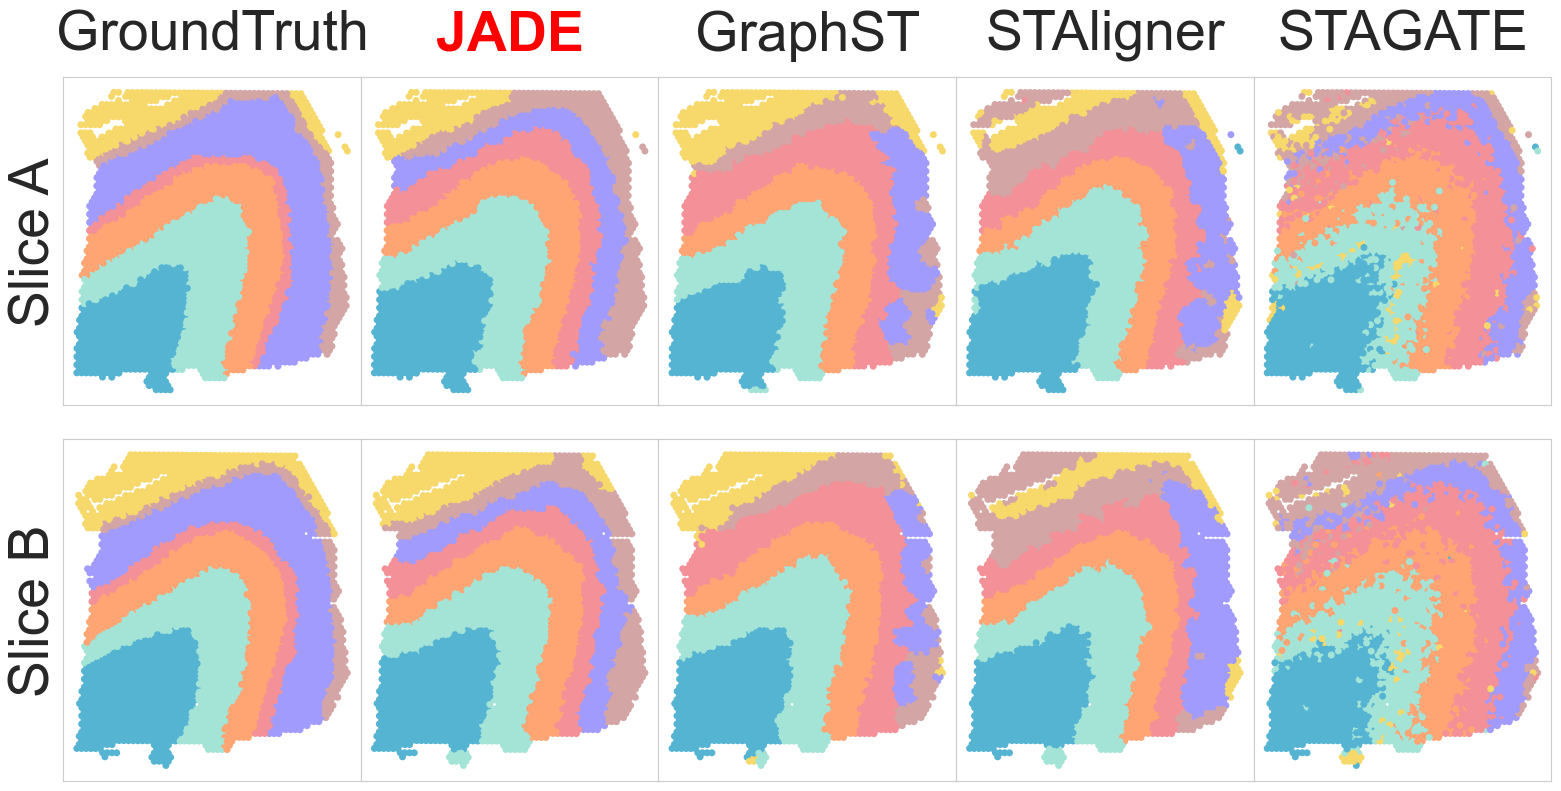

In [11]:
import numpy as np, matplotlib.pyplot as plt

# Load one NPZ -> list of slices [{spatial, domain}, ...]
def load_method(npz):
    z = np.load(npz, allow_pickle=True)
    L = int(z["ad_lengths"].shape[0])
    return [{"spatial": z[f"ad_{i}_spatial"], "domain": z[f"ad_{i}_domain"].astype(int)} for i in range(L)]

paths = {
    "GroundTruth": "./cached_results/dlpfc/groundtruth/info_2AB_lite.npz",
    "JADE":        "./cached_results/dlpfc/jade/info_2AB_lite.npz",
    "GraphST":     "./cached_results/dlpfc/mgraphst/info_2AB_lite.npz",
    "STAligner":   "./cached_results/dlpfc/staligner/info_2AB_lite.npz",
    "STAGATE":     "./cached_results/dlpfc/stagate/info_2AB_lite.npz",
}
order = list(paths)  # keep the dict insertion order

# palette 1..7
hexes = ["#56B4D3","#A3E4D7","#F49097","#F7D86A","#FFA473","#D4A5A5","#A29BFE"]
topic_color = np.array(hexes, dtype=object)

data = {k: load_method(p) for k,p in paths.items()}

fig, axes = plt.subplots(2, len(order), figsize=(16, 8.2),
                         gridspec_kw=dict(left=.05, right=.98, bottom=.00, top=.90, wspace=0, hspace=0))
for col, name in enumerate(order):
    for row, sl in enumerate(data[name]):
        ax = axes[row, col]
        dom = sl["domain"].astype(int)
        # map domain {1..7} -> palette; fallback to gray for out-of-range
        in_rng = (dom >= 1) & (dom <= len(topic_color))
        colors = np.full(dom.shape, "#999999", dtype=object)
        colors[in_rng] = topic_color[dom[in_rng]-1]
        ax.scatter(sl["spatial"][:,0], sl["spatial"][:,1], s=100, marker='.', linewidth=0, c=colors)
        ax.invert_yaxis(); ax.set_aspect('equal'); ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)
        if row == 0:
            if name in ("JADE","JADE-Fast"):
                ax.set_title(name, fontsize=40, pad=20, fontweight='bold', color="red")
            else:
                ax.set_title(name, fontsize=40, pad=20)

axes[0,0].set_ylabel("Slice A", rotation=90, fontsize=40, labelpad=20, va='center')
axes[1,0].set_ylabel("Slice B", rotation=90, fontsize=40, labelpad=20, va='center')
# plt.savefig("./fig/dlpfc/cluster_all.pdf", dpi=300, bbox_inches="tight")
plt.show()


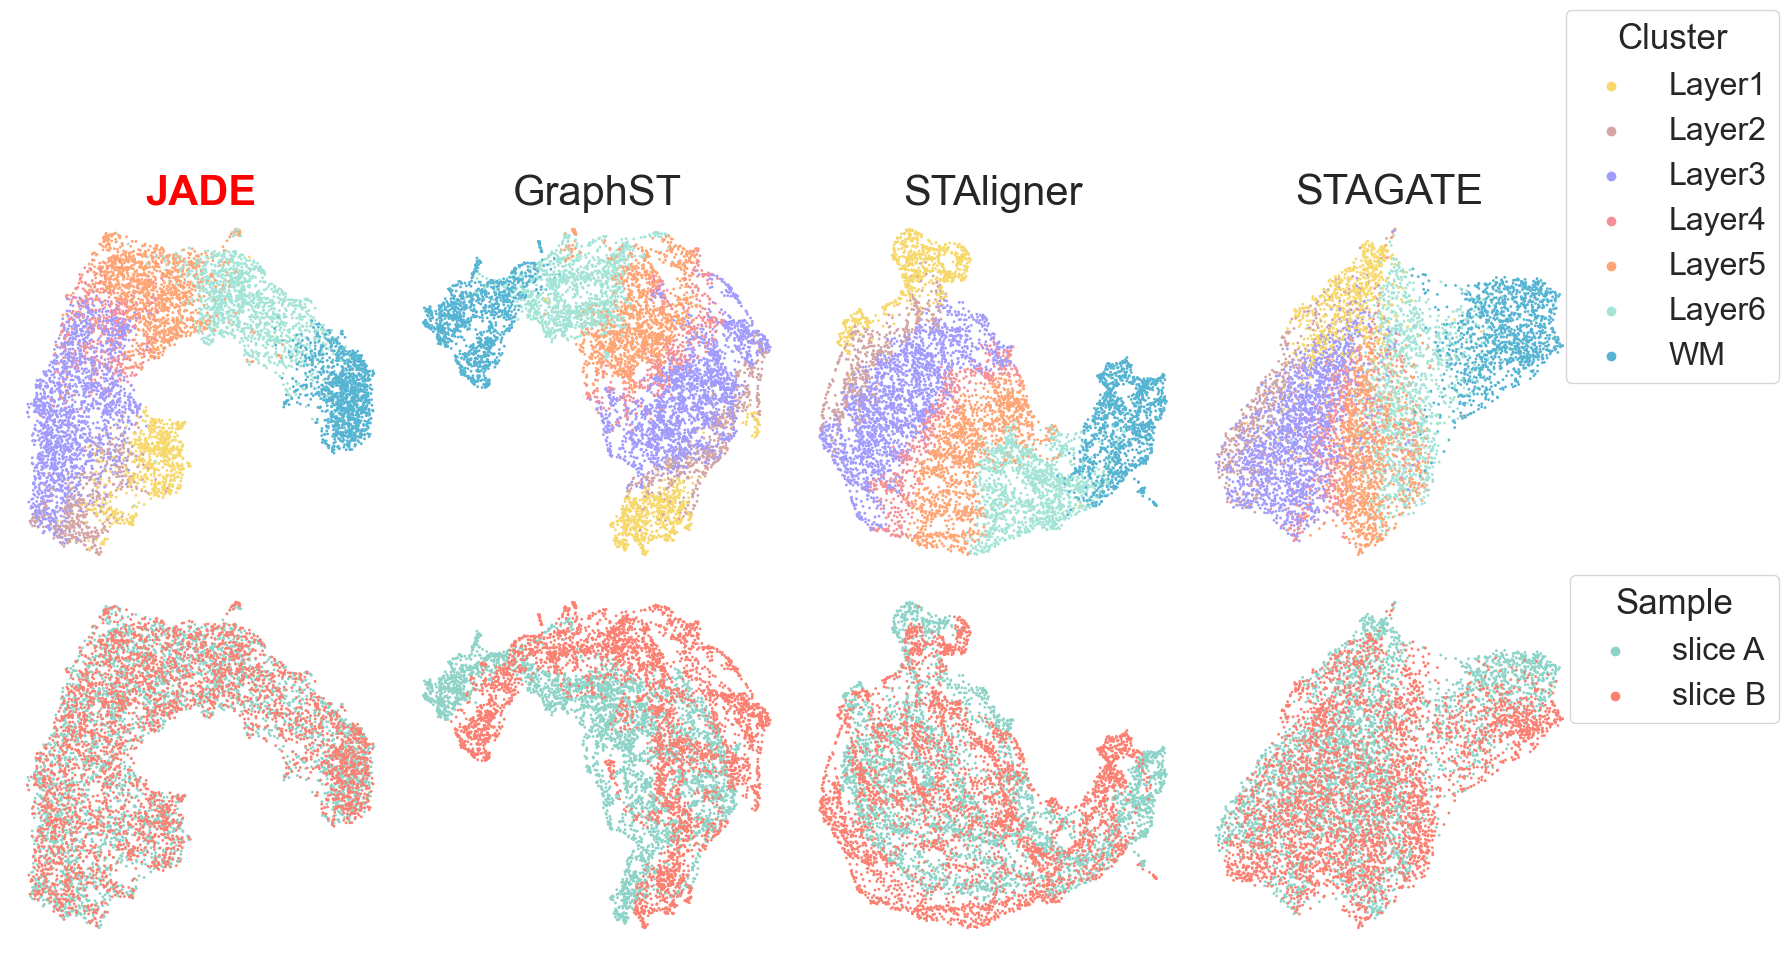

JADE       median iLISI = 1.983
GraphST    median iLISI = 1.516
STAligner  median iLISI = 1.636
STAGATE    median iLISI = 1.612


In [12]:
import numpy as np, pandas as pd, anndata as ad
import matplotlib.pyplot as plt, scanpy as sc
from sklearn.decomposition import PCA

# ---- config ----
paths = {
    "JADE":      "./cached_results/dlpfc/jade/info_2AB_lite.npz",
    "GraphST":   "./cached_results/dlpfc/mgraphst/info_2AB_lite.npz",
    "STAligner": "./cached_results/dlpfc/staligner/info_2AB_lite.npz",
    "STAGATE":   "./cached_results/dlpfc/stagate/info_2AB_lite.npz",
}
order = ["JADE","GraphST","STAligner","STAGATE"]

sample_colors = {
    'slice A':'#8DD3C7','slice B':'#FB8072',
    'Slice A':'#8DD3C7','Slice B':'#FB8072'
}
layer_colors  = {
    "Layer1":"#F7D86A","Layer2":"#D4A5A5","Layer3":"#A29BFE",
    "Layer4":"#F49097","Layer5":"#FFA473","Layer6":"#A3E4D7","WM":"#56B4D3"
}

# ---- helpers ----
def _decode(codes, cats):
    codes = np.asarray(codes, dtype=int)
    ca = np.asarray(cats, dtype=object)
    out = np.empty(codes.shape[0], dtype=object)
    mask = codes >= 0
    out[mask] = ca[codes[mask]]
    out[~mask] = "unknown"
    return pd.Categorical(out, categories=list(ca), ordered=False)

def load_as_adata(npz_path: str):
    """Load unified NPZ (per-slice + combined) and rebuild a minimal AnnData for plotting/iLISI."""
    z = np.load(npz_path, allow_pickle=True)

    # combined payload (names MUST match what we saved)
    idx   = z["combined_index"]
    emb   = z["combined_emb"]
    umap  = z["combined_umap"]
    sl    = _decode(z["combined_slice_codes"], z["combined_slice_cats"])
    ly    = _decode(z["combined_layer_codes"], z["combined_layer_cats"])

    obs = pd.DataFrame({
        "slice_id": sl,
        "layer_guess_reordered": ly,
    }, index=idx)

    A = ad.AnnData(X=np.empty((emb.shape[0], 0), dtype=np.float32), obs=obs)
    A.obsm["emb"] = np.asarray(emb, dtype=np.float32)
    A.obsm["X_umap"] = np.asarray(umap, dtype=np.float32)

    # also return n_A from per-slice section for iLISI
    nA = int(np.asarray(z["ad_lengths"])[0])
    return A, nA

# ---- load ----
adatas, nA_by_name = {}, {}
for name in order:
    A, nA = load_as_adata(paths[name])
    adatas[name] = A
    nA_by_name[name] = nA

# ---- plot UMAPs ----
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for col, name in enumerate(order):
    A = adatas[name]
    # bottom: by sample
    axb = axes[1, col]
    sc.pl.umap(A, color="slice_id", palette=sample_colors, ax=axb, show=False)
    axb.set_title(""); axb.axis("off")
    # top: by cluster
    axt = axes[0, col]
    sc.pl.umap(A, color="layer_guess_reordered", palette=layer_colors, ax=axt, show=False)
    title_kwargs = {"fontsize": 30}
    if name in ("JADE","JADE-Fast"):
        title_kwargs.update(fontweight="bold", color="red")
    axt.set_title(name, **title_kwargs)
    axt.axis("off")

# figure legends (if present)
for ax in axes.flatten():
    if getattr(ax, "legend_", None) is not None:
        ax.legend_.remove()
hs, ls = axes[1,0].get_legend_handles_labels()
hc, lc = axes[0,0].get_legend_handles_labels()
if hs and ls:
    fig.legend(hs, ls, title="Sample",  loc="upper right", bbox_to_anchor=(0.9, 0.5),
               fontsize=23, title_fontsize=25)
if hc and lc:
    fig.legend(hc, lc, title="Cluster", loc="lower right", bbox_to_anchor=(0.9, 0.7),
               fontsize=23, title_fontsize=25)

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

# ---- iLISI ----
n_pcs = 20
for name in order:
    emb = adatas[name].obsm["emb"]
    nA  = nA_by_name[name]
    batch = np.concatenate([np.zeros(nA, dtype=int),
                            np.ones(emb.shape[0]-nA, dtype=int)])
    emb_pca = PCA(n_components=n_pcs).fit_transform(emb)
    ilisi = compute_iLISI(emb_pca, batch, k=100)  # assumes your function is defined
    print(f"{name:10s} median iLISI = {np.mean(ilisi):.3f}")


### **Differential expression analysis**

In [13]:
# Rebuild any method’s per-slice AnnData (supports your HVG/DE code)
import numpy as np, pandas as pd
import anndata as ad
from scipy import sparse

def load_slice_from_npz(npz_path: str, i: int):
    z = np.load(npz_path, allow_pickle=True)
    # obs & var names
    obs_names = z[f"ad_{i}_obs"]
    var_names = z[f"ad_{i}_var"]
    # domain
    domain = z[f"ad_{i}_domain"].astype(int)
    obs = pd.DataFrame({"domain": pd.Categorical(domain.astype(str))}, index=obs_names)
    var = pd.DataFrame(index=var_names)
    # X
    fmt = str(z[f"ad_{i}_X_fmt"][0])
    if fmt == "csr":
        data    = z[f"ad_{i}_X_data"]
        indices = z[f"ad_{i}_X_indices"]
        indptr  = z[f"ad_{i}_X_indptr"]
        shape   = tuple(z[f"ad_{i}_X_shape"])
        X = sparse.csr_matrix((data, indices, indptr), shape=shape)
    else:  # dense fallback
        X = z[f"ad_{i}_X_dense"]
    A = ad.AnnData(X=X, obs=obs, var=var)
    return A

adatalist_jade = [load_slice_from_npz("./cached_results/dlpfc/jade/info_2AB_lite.npz", i) for i in range(2)]

In [14]:
import random
import torch
# set seed
SEED=23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
sc.settings.seed=SEED
# select HVGs, scale, and run PCA
adata=adatalist_jade[1]
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3",
                             min_mean=0.0125, max_mean=3, min_disp=0.5)
adata=adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10); sc.tl.pca(adata, svd_solver='arpack')

In [15]:
sc.tl.rank_genes_groups(adata, groupby='domain', method='wilcoxon', corr_method='bonferroni')
rg = adata.uns['rank_genes_groups']
for grp in rg['names'].dtype.names:
    print(f"\nTop 5 genes for {grp}:")
    df = pd.DataFrame({
        'gene':     rg['names'][grp][:5],
        'pval_adj': rg['pvals_adj'][grp][:5]
    })
    print(df.to_string(index=False))



Top 5 genes for 1:
  gene      pval_adj
   MBP  0.000000e+00
  PLP1  0.000000e+00
  GFAP 3.373317e-304
 PTGDS 1.098970e-256
TUBA1A 1.327707e-178

Top 5 genes for 2:
  gene     pval_adj
   MBP 3.577792e-50
  PLP1 4.233027e-30
TMSB10 5.961642e-30
 COX6C 3.724774e-22
   B2M 9.322822e-18

Top 5 genes for 3:
  gene     pval_adj
  NEFL 1.398904e-63
TUBA1B 6.853529e-31
  NRGN 1.202121e-26
 UCHL1 1.564454e-25
 MAP1B 4.025981e-23

Top 5 genes for 4:
   gene     pval_adj
 MALAT1 7.360144e-95
  COX6C 7.395646e-75
   CST3 7.797658e-37
   GFAP 1.024101e-17
CAMK2N1 2.335515e-17

Top 5 genes for 5:
  gene      pval_adj
TMSB10 1.227417e-115
SNAP25  3.118818e-76
TUBB2A  1.803990e-69
TUBA1B  6.551670e-68
  SYT1  7.296950e-59

Top 5 genes for 6:
   gene     pval_adj
   ENC1 5.055759e-84
CAMK2N1 6.018605e-75
 ARPP19 2.601272e-37
  OLFM1 1.480534e-30
   NCDN 3.345878e-29

Top 5 genes for 7:
  gene     pval_adj
  ENC1 1.008006e-69
 YWHAH 2.767588e-42
  NRGN 1.380996e-33
   CCK 1.997787e-32
MT-ND5 1.568992e

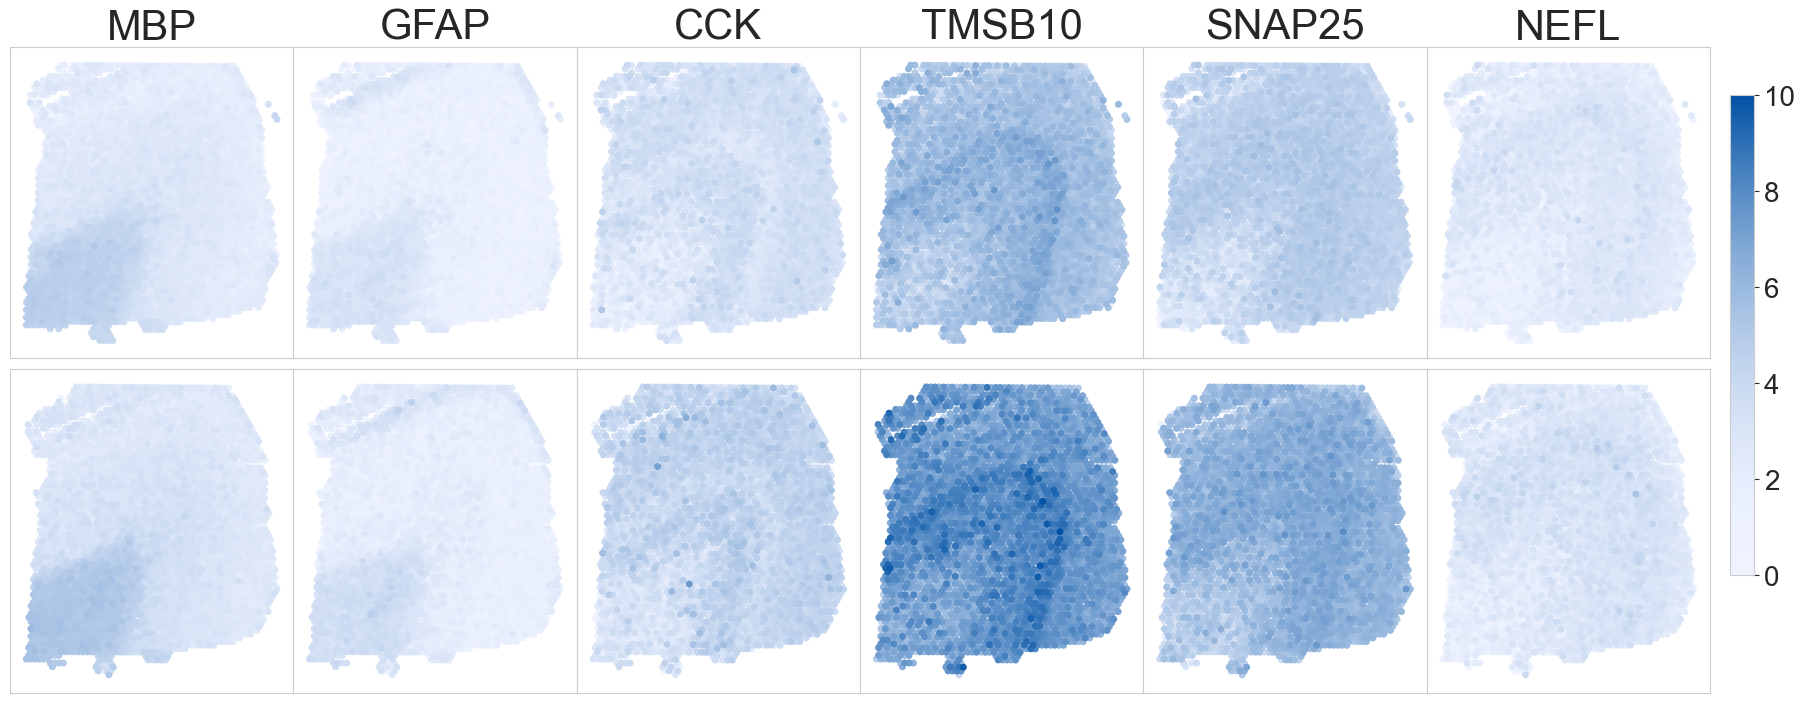

In [19]:
# NOTE: Plot marker genes
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mc, colorsys
import matplotlib.colorbar as cb
adata1 = adata_all["151673"].copy()
adata2 = adata_all["151674"].copy()
preprocess(adata1)
preprocess(adata2)
def increase_saturation(hex_color, factor):
    r, g, b = mcolors.hex2color(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    s = min(1.0, s * factor)
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return (r2, g2, b2)
orig = ["#eff3ff", "#08519c"]
sat_colors = [increase_saturation(c, 5.0) for c in orig]
blue2light = LinearSegmentedColormap.from_list(
    "blue2light_sqrt_dark",
    [mc.to_hex(colorsys.hls_to_rgb(*((lambda h,l,s:(h,l*1.0,s))(*colorsys.rgb_to_hls(*mc.to_rgb(increase_saturation(c,5.0))))))) for c in ["#eff3ff","#08519c"]],
    gamma=2.0
)
markers = ['MBP', 'GFAP', 'CCK', 'TMSB10', 'SNAP25', 'NEFL']
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 8))
vmin = np.inf
vmax = -np.inf
# Get global vmin/vmax
for adata_expr in [adata1.raw if adata1.raw is not None else adata1,
                   adata2.raw if adata2.raw is not None else adata2]:
    for marker in markers:
        vals = adata_expr[:, marker].X
        if hasattr(vals, "toarray"):  # handle sparse matrix
            vals = vals.toarray()
        vmin = min(vmin, np.min(vals))
        vmax = max(vmax, np.max(vals))
# Plot for both datasets
for i, adata in enumerate([adata1, adata2]):
    adata_expr = adata.raw if adata.raw is not None else adata
    for k, marker in enumerate(markers):
        sc.pl.spatial(
            adata,
            color=marker,
            spot_size=10,
            cmap=blue2light,
            ax=axes[i, k],
            title='',
            show=False,
            colorbar_loc=None,
            vmin=vmin,
            vmax=vmax
        )
        axes[i, k].set_xlabel('')
        axes[i, k].set_ylabel('')
        if i == 0:
            axes[i, k].set_title(marker, fontsize=30)
# Adjust spacing (more compact)
fig.subplots_adjust(
    left=0.03, right=0.88, top=0.92, bottom=0.1,
    wspace=0.0, hspace=0.00  # smaller spacing
)
# Shared colorbar
cmap = plt.get_cmap(blue2light)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
# Tighter colorbar
cbar_ax = fig.add_axes([0.89, 0.25, 0.012, 0.6])
cbar_ax.tick_params(labelsize=20) 
cb1 = cb.ColorbarBase(cbar_ax, cmap=blue2light, norm=norm)
# Save & show
# plt.savefig("./fig/dlpfc/marker_genes.pdf", dpi=300, bbox_inches='tight')
plt.show()

### **ARI and alignment score**

In [20]:
from plotnine import geom_segment, annotate
from plotnine import aes
import itertools
from scipy.stats import mannwhitneyu
from plotnine import (
    ggplot, aes, geom_boxplot, coord_flip, theme_bw, labs,
    theme, element_text, geom_bar, geom_text,
    element_blank, scale_fill_manual, scale_fill_discrete,
    theme_void, coord_cartesian, ggtitle, geom_col, facet_wrap
)

def pairwise_pvals(df, methods, alternative="greater"):
    """
    Returns a dict mapping (m1, m2) → p-value for the hypothesis
    ARI(m1) > ARI(m2), via a one-sided Mann–Whitney U test.
    """
    pvals = {}
    for m1, m2 in itertools.combinations(methods, 2):
        x = df.loc[df.Method == m1, "ARI"]
        y = df.loc[df.Method == m2, "ARI"]
        _, p = mannwhitneyu(x, y, alternative=alternative)
        pvals[(m1, m2)] = p
    return pvals


from plotnine import geom_segment, annotate
def stars_for_p(p):
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return "ns"    # or return "" if you’d rather omit non‑significant
    
def add_p_annotations(
    plot,
    df,
    pvals,
    methods,
    step_factor: float = 0.03,
    cap_height_factor: float = 0.2,
    text_size: float = 12,
    gap: float = 0.75
):
    y_min, y_max = df.ARI.min(), df.ARI.max()
    yrange = y_max - y_min
    step = yrange * step_factor
    cap  = step * cap_height_factor

    for i, ((m1, m2), p) in enumerate(pvals.items()):
        x1 = methods.index(m1) + 1
        x2 = methods.index(m2) + 1
        y  = y_max + step * i
        y0 = y_max + step * i
        xmid = (x1 + x2)/2
        total = x2 - x1
        # gap   = total * gap_fraction
        segment_size = 0.1
        linetype="dashed"

        # left dash: from x1 to just before the gap
        plot += geom_segment(
            aes(x=x1, xend=xmid - gap/2, y=y0, yend=y0),
            inherit_aes=False,
            size=segment_size,
            linetype=linetype
        )
        # right dash: from just after the gap to x2
        plot += geom_segment(
            aes(x=xmid + gap/2, xend=x2, y=y0, yend=y0),
            inherit_aes=False,
            size=segment_size,
            linetype=linetype
        )

        # vertical caps
        for x in (x1, x2):
            plot += geom_segment(
                aes(x=x, xend=x, y=y0, yend=y0 - cap),
                inherit_aes=False,
                size=segment_size,
                linetype=linetype
            )
        # now annotate stars rather than p-value
        stars = stars_for_p(p)
        if stars != "ns":    # omit non‑significant if you like
            plot += annotate(
                "text",
                x=(x1 + x2)/2,
                y=y + cap*0.1,
                label=stars,
                size=text_size,
                ha="center", va="center",\
                color="black"
            )

    return plot


In [21]:
group = 2 
srcidx = 0
df_loaded = pd.read_csv(f'./cached_results/dlpfc/jade/group_{group}_srcidx_{srcidx}.csv')
aris1_jade = df_loaded['aris1'].tolist()
aris2_jade = df_loaded['aris2'].tolist()
align_jade = df_loaded['align'].tolist()

df_loaded = pd.read_csv(f'./cached_results/dlpfc/staligner/group_{group}_srcidx_{srcidx}.csv')
aris1_staligner = df_loaded['aris1'].tolist()
aris2_staligner = df_loaded['aris2'].tolist()
align_staligner = df_loaded['align'].tolist()

df_loaded = pd.read_csv(f'./cached_results/dlpfc/mgraphst/group_{group}_srcidx_{srcidx}.csv')
aris1_graphst = df_loaded['aris1'].tolist()
aris2_graphst = df_loaded['aris2'].tolist()

df_loaded = pd.read_csv(f'./cached_results/dlpfc/stagate/group_{group}_srcidx_{srcidx}.csv')
aris1_stagate = df_loaded['aris1'].tolist()
aris2_stagate = df_loaded['aris2'].tolist()


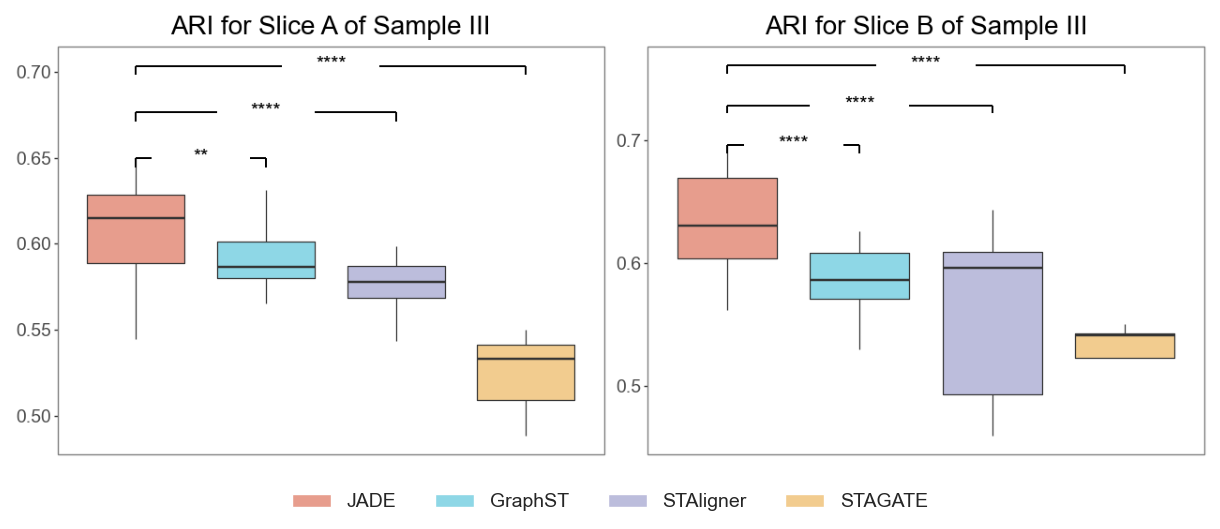

In [22]:
df1 = pd.DataFrame({
    'Method': ['JADE'] * len(aris1_jade) +
              ['GraphST'] * len(aris1_graphst) +
              ['STAligner'] * len(aris1_staligner) +
              ['STAGATE'] * len(aris1_stagate),
    'ARI':    aris1_jade + aris1_graphst + aris1_staligner + aris1_stagate
})
df2 = pd.DataFrame({
    'Method': ['JADE'] * len(aris2_jade) +
              ['GraphST'] * len(aris2_graphst) +
              ['STAligner'] * len(aris2_staligner) +
              ['STAGATE'] * len(aris2_stagate),
    'ARI':    aris2_jade + aris2_graphst + aris2_staligner + aris2_stagate
})
order = ["JADE", "GraphST", "STAligner", "STAGATE"]
df1["Method"] = pd.Categorical(df1["Method"], categories=order, ordered=True)
df2["Method"] = pd.Categorical(df2["Method"], categories=order, ordered=True)
custom_colors = {"JADE":"#E79D8D","GraphST":"#8ED7E6","STAligner":"#BCBDDC","STAGATE":"#F2CC8F"}
base_theme = theme_bw() + theme(
    legend_position='none',
    axis_text_x=element_blank(),
    axis_ticks_major_x=element_blank(),
    axis_text_y=element_text(size=14),
    axis_title=element_blank(),
    plot_title=element_text(size=20),
    panel_grid_major=element_blank(),
    panel_grid_minor=element_blank()
)
p1 = (ggplot(df1, aes('Method','ARI',fill='Method'))
      + geom_boxplot(outlier_shape="", outlier_size=0)
      + scale_fill_manual(values=custom_colors)
      + ggtitle("ARI for Slice A of Sample III")
      + base_theme)
p2 = (ggplot(df2, aes('Method','ARI',fill='Method'))
      + geom_boxplot(outlier_shape="", outlier_size=0)
      + scale_fill_manual(values=custom_colors)
      + ggtitle("ARI for Slice B of Sample III")
      + base_theme)
methods = order
mask = [('JADE','GraphST'),('JADE','STAligner'),('JADE','STAGATE')]
p1 = add_p_annotations(p1, df1,
                      {m: pairwise_pvals(df1, methods, alternative="greater")[m] for m in mask},
                      methods, step_factor=0.15, cap_height_factor=0.2, text_size=15)
p2 = add_p_annotations(p2, df2,
                      {m: pairwise_pvals(df2, methods, alternative="greater")[m] for m in mask},
                      methods, step_factor=0.1, cap_height_factor=0.2, text_size=15)
fig1 = p1.draw(); fig1.canvas.draw(); img1 = np.asarray(fig1.canvas.buffer_rgba())
fig2 = p2.draw(); fig2.canvas.draw(); img2 = np.asarray(fig2.canvas.buffer_rgba())
from matplotlib.patches import Patch
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, img in zip(axs, (img1, img2)): ax.imshow(img); ax.axis('off')
handles = [Patch(facecolor=custom_colors[m], label=m) for m in order]
fig.legend(handles, order, loc='lower center', ncol=4, bbox_to_anchor=(0.5,0.04), frameon=False, fontsize=14)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.06, wspace=0)
# fig.savefig('./fig/dlpfc/ARI_all.pdf', dpi=300, bbox_inches='tight', pad_inches=0)


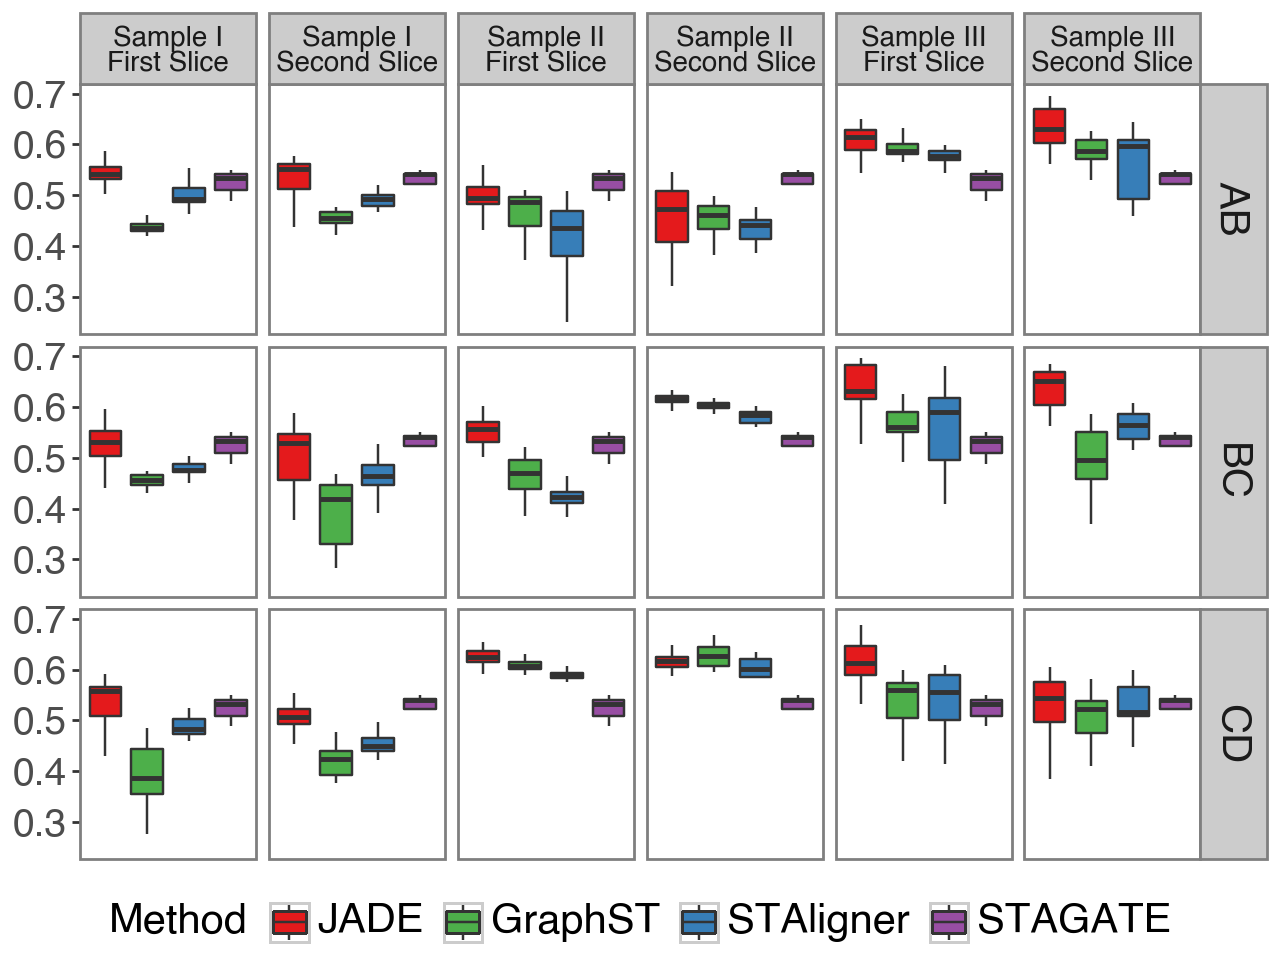

In [23]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_boxplot, facet_grid,
    labs, scale_fill_manual, theme_bw, theme,
    element_text, element_blank
)
groups      = [0,1,2]
srcidx_list = [0,1,2]
order = ["JADE", "GraphST", "STAligner", "STAGATE"]
custom_colors = {
    "JADE":      "#e41a1c",
    "GraphST":   "#4daf4a",
    "STAligner": "#377eb8",
    "STAGATE":   "#984ea3",
}
all_dfs = []
for group in groups:
    for srcidx in srcidx_list:
        df_loaded = pd.read_csv(f'./cached_results/dlpfc/jade/group_{group}_srcidx_{srcidx}.csv')
        aris1_jade = df_loaded['aris1'].tolist()
        aris2_jade = df_loaded['aris2'].tolist()
        align_jade = df_loaded['align'].tolist()
        df_loaded = pd.read_csv(f'./cached_results/dlpfc/staligner/group_{group}_srcidx_{srcidx}.csv')
        aris1_staligner = df_loaded['aris1'].tolist()
        aris2_staligner = df_loaded['aris2'].tolist()
        align_staligner = df_loaded['align'].tolist()
        df_loaded = pd.read_csv(f'./cached_results/dlpfc/mgraphst/group_{group}_srcidx_{srcidx}.csv')
        aris1_graphst = df_loaded['aris1'].tolist()
        aris2_graphst = df_loaded['aris2'].tolist()
        df_loaded = pd.read_csv(f'./cached_results/dlpfc/stagate/group_{group}_srcidx_{srcidx}.csv')
        aris1_stagate = df_loaded['aris1'].tolist()
        aris2_stagate = df_loaded['aris2'].tolist()
        for (vals, slice_name) in [
            (aris1_jade  + aris1_graphst  + aris1_staligner  + aris1_stagate,  'First Slice'),
            (aris2_jade  + aris2_graphst  + aris2_staligner  + aris2_stagate,  'Second Slice'),
        ]:
            methods = (['JADE'] * len(vals[:len(aris1_jade)]) +
                       ['GraphST'] * len(vals[len(aris1_jade):len(aris1_jade)+len(aris1_graphst)]) +
                       ['STAligner'] * len(vals[len(aris1_jade)+len(aris1_graphst):
                                                   len(aris1_jade)+len(aris1_graphst)+len(aris1_staligner)]) +
                       ['STAGATE'] * len(vals[-len(aris1_stagate):]))
            df = pd.DataFrame({
                'Method': methods,
                'ARI':    vals
            })
            group_labels = {0: "Sample I", 1: "Sample II", 2: "Sample III"}
            df['Group'] = group_labels[group]
            df['Slice']  = slice_name
            df['srcidx'] = ['AB','BC','CD'][srcidx]
            all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df['Method'] = pd.Categorical(df['Method'], categories=order, ordered=True)

(
    ggplot(df, aes(x='Method', y='ARI', fill='Method'))
    + geom_boxplot(outlier_shape="", outlier_size=0)
    # rows = srcidx (AB,BC,CD), cols = Group + Slice
    + facet_grid('srcidx ~ Group + Slice')
    + scale_fill_manual(values=custom_colors)
    + labs(x=None, y="ARI")
    + theme_bw()
    + theme(
        legend_position="bottom",
        legend_text=element_text(size=15),
        legend_title=element_text(size=15),
        axis_text_x=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_text_y=element_text(size=14),
        axis_title_x=element_blank(),  # redundant once labs(x=None), but safe
        axis_title_y=element_blank(),
        panel_grid=element_blank(),
        strip_text=element_text(size=10),
        strip_text_y      = element_text(size=15),
        strip_text_x      = element_text(size=10),
    )
)


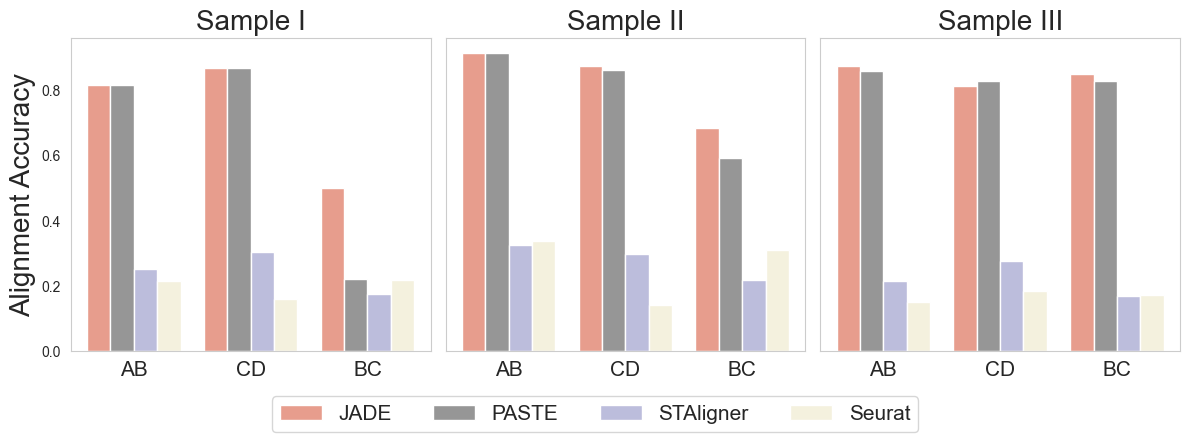

In [24]:
align_all_jade = [
    [pd.read_csv(f'./cached_results/dlpfc/jade/group_{g}_srcidx_{s}.csv')['align'].mean() for s in range(3)]
    for g in range(3)
]
align_all_staligner = [
    [pd.read_csv(f'./cached_results/dlpfc/staligner/group_{g}_srcidx_{s}.csv')['align'].mean() for s in range(3)]
    for g in range(3)
]
align_all_paste = [
    [pd.read_csv(f'./cached_results/dlpfc/paste/group_{g}_srcidx_{s}.csv')['align'].mean() for s in range(3)]
    for g in range(3)
]
align_all_seurat = [
    [pd.read_csv(f'./cached_results/dlpfc/seurat/group_{g}_srcidx_{s}.csv')['align'].mean() for s in range(3)]
    for g in range(3)
]

cases = ['AB','CD','BC']
methods = ['JADE','PASTE','STAligner','Seurat']
colors = ['#E79D8D','#969696','#BCBDDC','#F4F1DE']
sample_data = {
    'Sample I':   np.array([align_all_jade[0],align_all_paste[0],align_all_staligner[0],align_all_seurat[0]]),
    'Sample II':  np.array([align_all_jade[1],align_all_paste[1],align_all_staligner[1],align_all_seurat[1]]),
    'Sample III': np.array([align_all_jade[2],align_all_paste[2],align_all_staligner[2],align_all_seurat[2]])
}
sample_data = {k: v[:,[0,2,1]] for k,v in sample_data.items()}

bar_width = 0.2
x = np.arange(len(cases))
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
for ax,(name,acc) in zip(axes,sample_data.items()):
    for i,m in enumerate(methods):
        ax.bar(x+i*bar_width, acc[i], bar_width, label=m, color=colors[i])
    ax.set_title(name, fontsize=20)
    ax.set_xticks(x+bar_width*(len(methods)-1)/2)
    ax.set_xticklabels(cases, fontsize=15)
    ax.grid(False)
axes[0].set_ylabel('Alignment Accuracy', fontsize=20)
fig.legend(methods, fontsize=15, loc='lower center', bbox_to_anchor=(0.5,-0.12), ncol=len(methods))
plt.tight_layout(rect=[0,0,1,1])
# fig.savefig("./fig/dlpfc/Alignment_all.pdf",dpi=300,bbox_inches="tight")
plt.show()

### **Alignment**

In [25]:
from scipy.io import mmread

pi_jade = np.load("./cached_results/dlpfc/jade/2AB_spot_align.npy")
pi_staligner = np.load("./cached_results/dlpfc/staligner/2AB_spot_align.npy")
pi_seurat = mmread("./cached_results/dlpfc/seurat/2AB_spot_align.mtx").toarray()
pi_paste = np.load("./cached_results/dlpfc/paste/2AB_spot_align.npy")

In [26]:
# compute accuracy
for clust in ['Layer'+str(k+1) for k in range(6)]+['WM']:
    top = 250
    i_mask = np.arange(adata1.shape[0])[adata1.obs['layer_guess_reordered']==clust]
    j_mask = np.arange(adata2.shape[0])[adata2.obs['layer_guess_reordered']==clust]
    print(clust,top, compute_cluster_accuracy(adata1, adata2, col_normalize(pi_jade), top=top, cluster=clust),
    compute_cluster_accuracy(adata1, adata2, col_normalize(pi_paste), top=top, cluster=clust),
    compute_cluster_accuracy(adata1, adata2, col_normalize(pi_staligner), top=top, cluster=clust),
    compute_cluster_accuracy(adata1, adata2, col_normalize(pi_seurat), top=top, cluster=clust),)

Layer1 250 0.996 1.0 0.936 0.016
Layer2 250 0.636 0.584 0.648 0.084
Layer3 250 0.908 0.84 0.832 0.136
Layer4 250 0.776 0.724 0.252 0.296
Layer5 250 0.912 0.848 0.752 0.276
Layer6 250 0.752 0.836 0.74 0.344
WM 250 1.0 1.0 0.992 0.02


In [27]:
# New: version that draws onto a given Axes
def plot_slice_pairwise_alignment_ax(
    ax,
    slice1,
    slice2,
    labels1,
    labels2,
    pi,
    thr=1-1e-8,
    alpha=0.05,
    top=1000,
    weight_alpha=False,
    cluster=None
):
    
    # scatter spots
    import matplotlib.colors as mcolors
    import colorsys
    def desaturate(color, factor=0.6):
        r, g, b = mcolors.to_rgb(color)
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        r2, g2, b2 = colorsys.hls_to_rgb(h, l, s*factor)
        return mcolors.to_hex((r2, g2, b2))
    
    # coordinates and offset
    coords1 = slice1.obsm['spatial']
    coords2 = slice2.obsm['spatial']
    offset = (coords1[:,0].max() - coords2[:,0].min()) * 1.1
    coords2_off = coords2 + np.array([offset, 0])

    # mask to cluster if requested
    if cluster is not None:
        mask = (slice1.obs['layer_guess_reordered'] == cluster).to_numpy()
        pi_masked = pi.copy()
        pi_masked[~mask, :] = -1
    else:
        mask = np.ones(len(coords1), bool)
        pi_masked = pi

    # pick top matches
    i_idx, j_idx = largest_indices(pi_masked, top)
    G_masked = np.zeros_like(pi)
    G_masked[i_idx, j_idx] = pi_masked[i_idx, j_idx]

    # draw lines
    mx = pi.max() if pi.size>0 else 1.0
    for i, j in zip(i_idx, j_idx):
        correct = (labels1[i] == labels2[j])
        col = desaturate('blue',0.8) if correct else desaturate('yellow',0.8)
        a = alpha*(1-weight_alpha) + (weight_alpha * pi[i,j]/mx)
        ax.plot(
            [coords1[i,0], coords2_off[j,0]],
            [coords1[i,1], coords2_off[j,1]],
            color=col, alpha=2.0*a, linewidth=10.0
        )

    raw = ["F7D86A","D4A5A5","A29BFE","F49097","FFA473","A3E4D7","56B4D3"]
    new_colors = [f"#{h}" for h in raw]
    cats = adata1.obs['layer_guess_reordered'].cat.categories.tolist()
    orig_cmap = {cat: new_colors[i] for i,cat in enumerate(cats)}

    # 2) build new cmap by mapping each original color through `desaturate`
    new_cmap = { cat: desaturate(col, factor=0.6) 
                for cat, col in orig_cmap.items() }

    cols1 = [new_cmap.get(cat, "#cccccc")
         for cat in slice1.obs['layer_guess_reordered']]
    cols2 = [new_cmap.get(cat, "#cccccc")
         for cat in slice2.obs['layer_guess_reordered']]

    ax.scatter(coords1[:,0], coords1[:,1], s=100, marker='.', color=cols1)
    ax.scatter(coords2_off[:,0], coords2_off[:,1], s=100, marker='.', color=cols2)

    ax.invert_yaxis()
    ax.axis('off')
    
    return i_idx, j_idx


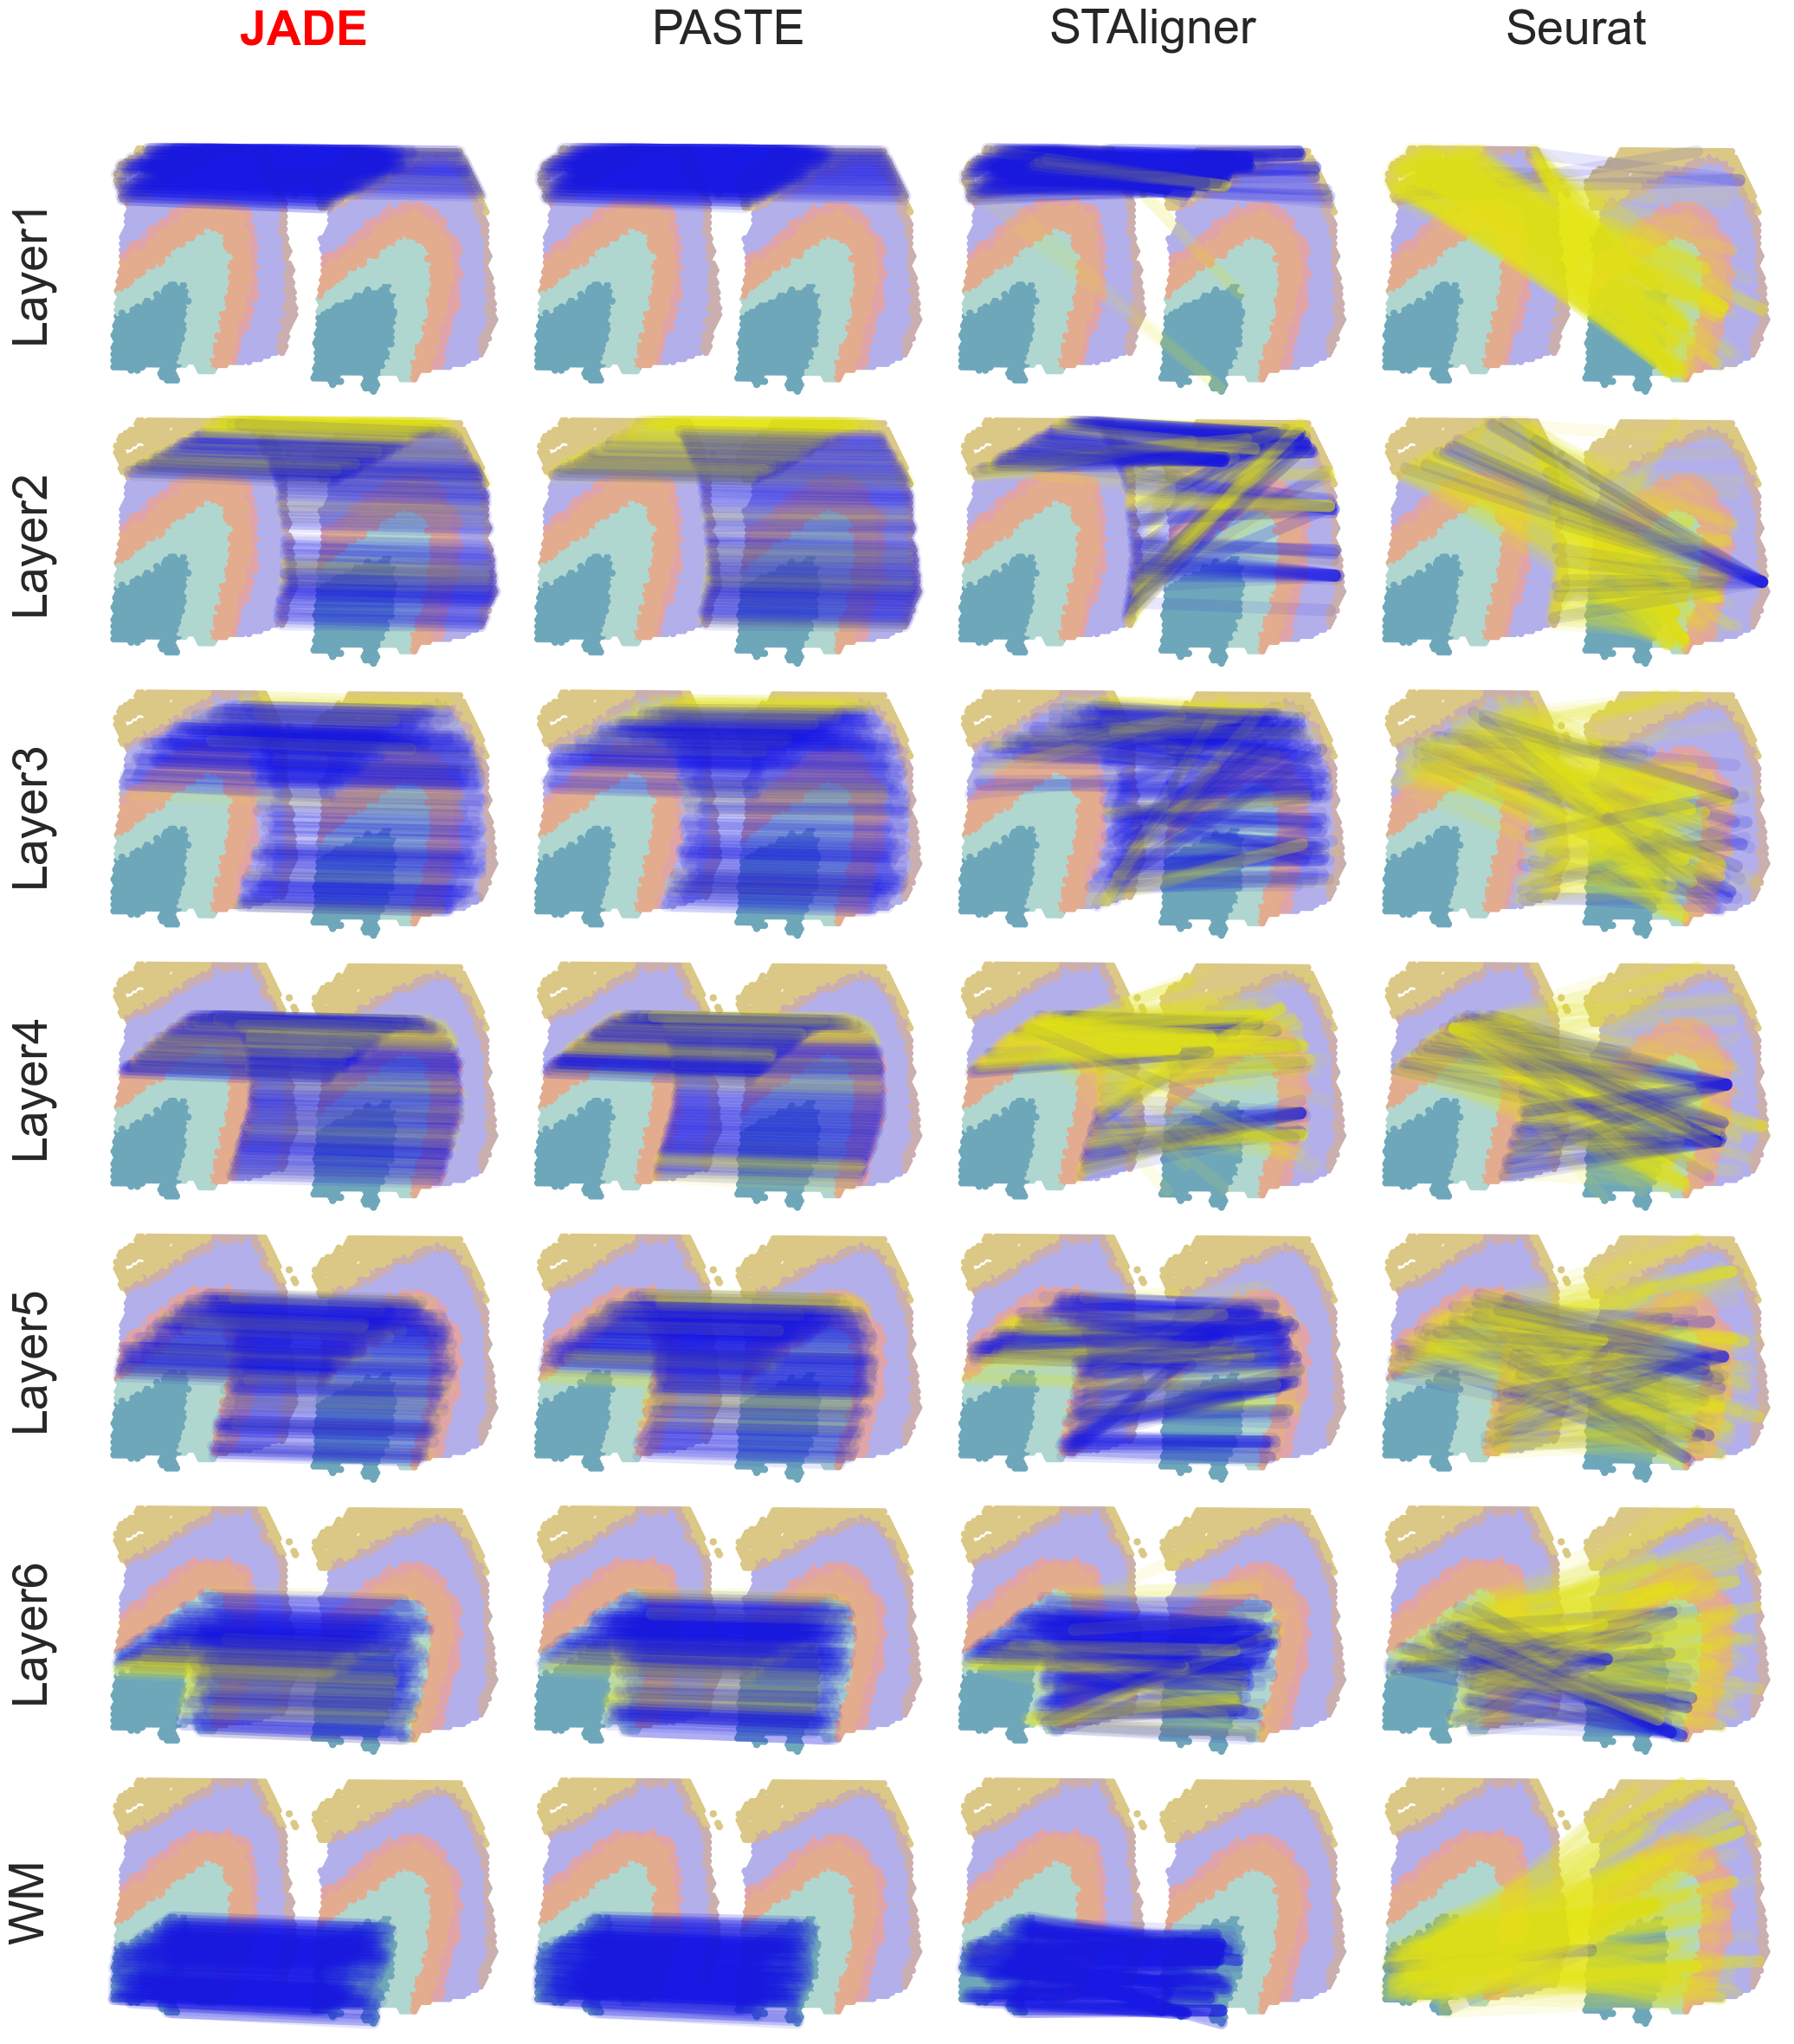

In [28]:
cluster_list = [f'Layer{k+1}' for k in range(6)] + ['WM']
methods_pis  = [
    col_normalize(pi_jade),
    pi_paste,
    col_normalize(pi_staligner),
    col_normalize(pi_seurat),
]
titles       = ['JADE', 'PASTE', 'STAligner', 'Seurat']
top = 250
# 1) Make the 7×4 grid
fig, axes = plt.subplots(
    nrows=len(cluster_list),
    ncols=len(methods_pis),
    figsize=(24, 24),
    squeeze=False
)
# 2) Plot everything, clear ticks
for i, clust in enumerate(cluster_list):
    for j, pi_mat in enumerate(methods_pis):
        ax = axes[i, j]
        plot_slice_pairwise_alignment_ax(
            ax,
            adata1,
            adata2,
            adata1.obs['layer_guess_reordered'],
            adata2.obs['layer_guess_reordered'],
            pi_mat,
            top=top,
            cluster=clust
        )
        ax.set_xticks([]); ax.set_yticks([])
# 3) Tighten up and leave space on left/top
plt.tight_layout(h_pad=0.5, w_pad=0.5)
fig.subplots_adjust(left=0.18, top=0.92)
# 4) Column headers exactly above each first-row axis
for j, title in enumerate(titles):
    ax0 = axes[0, j]
    pos = ax0.get_position()
    x_center = pos.x0 + pos.width/2
    if title == 'JADE':
        fig.text(
            x_center, 0.96, title,
            ha='center', va='bottom',
            fontsize=40, color='red', fontweight='bold'
        )
    else:
        fig.text(
            x_center, 0.96, title,
            ha='center', va='bottom',
            fontsize=40
        )
# 5) Row labels exactly beside each first-column axis
for i, clust in enumerate(cluster_list):
    ax0 = axes[i, 0]
    pos = ax0.get_position()
    y_center = pos.y0 + pos.height/2
    fig.text(
        pos.x0 - 0.02, y_center, clust,
        ha='right', va='center',
        rotation=90,
        fontsize=40
    )
# 6) Save
# plt.savefig("fig/supp/align_all_dlpfc.png", dpi=150, bbox_inches="tight")
plt.show()
